# Human Emotion Recognition

### Personal Project

Nina Cardenas

## 0. Initialization and setup

In [261]:
!pip install plotly
!pip install matplotlib
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install -U scikit-learn
!pip install scipy

In [262]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
import tensorflow as tf
import sklearn.model_selection as model_selection
import keras
import scipy
from keras.preprocessing.image import ImageDataGenerator

## 1. Data Collection

In [210]:
dataset = pd.read_csv("fer2013.csv")
labels = ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]
labels_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

In [175]:
dataset.shape

(35887, 3)

In [176]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


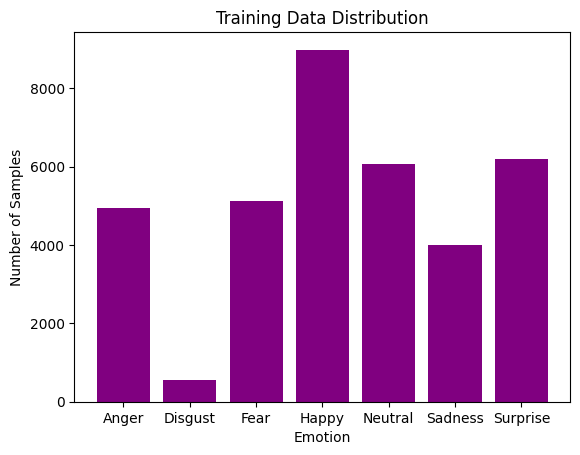

In [177]:
plt.title("Training Data Distribution")
plt.bar(labels, [list(dataset['emotion']).count(i) for i in np.unique(dataset['emotion'])], color="purple")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")

plt.show()

## 2. Preprocessing

In [178]:
# shuffle dataset
df = dataset.sample(frac=1,random_state=1)
df

,emotion,pixels,Usage
35624,0,122 107 68 76 101 125 141 144 143 159 161 123 ...,PrivateTest
12788,3,151 151 165 135 131 141 185 164 140 160 163 12...,Training
7821,3,88 68 83 107 84 62 91 147 159 159 158 154 150 ...,Training
31831,6,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 109 193 177 ...,PublicTest
16799,3,231 193 124 96 115 107 84 76 84 84 79 72 67 58...,Training
...,...,...,...
7813,3,85 70 50 57 86 138 150 124 142 147 138 125 129...,Training
32511,0,251 251 235 196 157 138 129 133 93 86 74 78 11...,PrivateTest
5192,4,14 15 16 14 12 13 14 13 13 10 8 12 11 6 14 21 ...,Training
12172,3,202 199 189 181 174 180 162 135 138 161 154 14...,Training


In [179]:
# one hot enconding
onehot_labels = ks.utils.to_categorical(data[['emotion']], num_classes=7)

In [180]:
#train = df[df['Usage'] == 'Training]

In [193]:
train = np.float32(df['pixels'].astype('str').str.split(" ").tolist())
train.shape

(35887, 2304)

In [186]:
np.amax(train) #maximum value in unscaled data

255

In [187]:
np.amin(train) # minimum value in unscaled data

0

In [194]:
train = train / 255.0
train

array([[0.47843137, 0.41960785, 0.26666668, ..., 0.5294118 , 0.54509807,
        0.56078434],
       [0.5921569 , 0.5921569 , 0.64705884, ..., 0.19607843, 0.3254902 ,
        0.29803923],
       [0.34509805, 0.26666668, 0.3254902 , ..., 0.81960785, 0.89411765,
        0.9490196 ],
       ...,
       [0.05490196, 0.05882353, 0.0627451 , ..., 0.28627452, 0.5647059 ,
        1.        ],
       [0.7921569 , 0.78039217, 0.7411765 , ..., 0.4862745 , 0.44313726,
        0.43137255],
       [0.11372549, 0.10980392, 0.11372549, ..., 0.9647059 , 0.81960785,
        0.8       ]], dtype=float32)

In [197]:
from math import sqrt
sqrt(2304)

48.0

In [198]:
data = train.reshape((35887,48,48,1))

In [204]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, onehot_labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [263]:
datagen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valgen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [264]:
datagen.fit(X_train)
valgen.fit(X_val)

In [265]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

## 3. ConvNet Model

In [266]:
# defining cnn model layers
model = keras.Sequential([
    # layer 1 (conv2d)
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', kernel_initializer="random_normal", input_shape=(48, 48, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    # layer 2 (conv2d)
    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # layer 3 (conv2d)
    keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same', activation='relu', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
     # flattening
    keras.layers.Flatten(input_shape=(28, 28)),
    
    # layer 4 (dense)
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.BatchNormalization(),
    
    # layer 5 (dense)
    keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # layer 6 (dense)
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [267]:
# printing model summary
model.summary()

# compiling model using adam optimizer and categorical ce loss function
# only metric analyzed is accuracy
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), #'adam'
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_56 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_56 (Bat  (None, 12, 12, 64)     

In [269]:
#model.fit(train_generator, epochs=5,verbose=0,batch_size=100, validation_data=val_generator)
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=0,
                    validation_data=val_generator)

#test_loss, test_acc = model.evaluate(X_test, y_test)

#print('Test accuracy:', test_acc)

NameError: name 'scipy' is not defined